In [3]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline  

In [2]:
import numpy as np
import pandas as pd
import datetime
import xarray as xr
from dateutil.relativedelta import relativedelta
from climate_drought import config, drought_indices as dri, utils, noaa_download as nd

#pd.set_option('display.max_rows', 500)


In [9]:
latitude=52.5
longitude=1.25
start_date='20200121'
end_date='20221231'
nd.get_nclimgrid(latitude,longitude,start_date,end_date,nd.NClimGridParams.PRECIPITATION,out_filepath='test4.nc')

In [86]:
# configure inputs
#aa = config.AnalysisArgs(latitude=36,longitude=-120,start_date='20220101',end_date='20221231')
#aa = config.AnalysisArgs(latitude=36,longitude=
# -120,start_date='20191211',end_date='20200101')
aa = config.AnalysisArgs(latitude=52.5,longitude=1.25,start_date='20200121',end_date='20221231')
cf = config.Config(outdir= 'output',indir='input',verbose=False)

In [81]:
cdi = dri.CDI(cf,config.CDIArgs(aa.latitude,aa.longitude,aa.start_date,aa.end_date,spi_source='GDO'))
cdi.download()

2023-05-19  11:54:47 INFO Successfully retrieved URL for GDO file with year: 2019, prod_code spg03
2023-05-19  11:54:47 INFO Successfully retrieved URL for GDO file with year: 2020, prod_code spg03
2023-05-19  11:54:48 INFO Successfully retrieved URL for GDO file with year: 2021, prod_code spg03
2023-05-19  11:54:48 INFO Successfully retrieved URL for GDO file with year: 2022, prod_code spg03
2023-05-19  11:54:48 INFO Successfully retrieved URL for GDO file with year: 2020, prod_code smant
2023-05-19  11:54:48 INFO Couldn't retrieve URL for GDO file with year: 2020, prod_code smand
2023-05-19  11:54:49 INFO Successfully retrieved URL for GDO file with year: 2021, prod_code smant
2023-05-19  11:54:49 INFO Couldn't retrieve URL for GDO file with year: 2021, prod_code smand
2023-05-19  11:54:49 INFO Successfully retrieved URL for GDO file with year: 2022, prod_code smant
2023-05-19  11:54:50 INFO Couldn't retrieve URL for GDO file with year: 2022, prod_code smand
2023-05-19  11:54:50 INFO

[None, None, None]

In [82]:
cdi.process()

2023-05-19  11:54:58 INFO Computing Combined Drought Indicator...
2023-05-19  11:54:58 WARNING Outfile not written: already exists
2023-05-19  11:54:59 WARNING Outfile not written: already exists
2023-05-19  11:54:59 WARNING Outfile not written: already exists
2023-05-19  11:54:59 INFO Completed processing of ERA5 CDI data.


,spg03,smant,fpanv,CDI
2019-12-01,NaN,NaN,NaN,NaN
2019-12-11,NaN,NaN,NaN,NaN
2019-12-21,NaN,NaN,NaN,NaN
2020-01-01,1.042,NaN,NaN,NaN
2020-01-11,1.042,NaN,NaN,NaN
...,...,...,...,...
2022-11-11,-0.900,-1.81,1.78,0.0
2022-11-21,-0.900,-0.40,NaN,NaN
2022-12-01,0.579,NaN,NaN,NaN
2022-12-11,0.579,NaN,NaN,NaN


In [51]:
cdi.data

,spg03,smant,fpanv,CDI
2018-12-01,NaN,NaN,NaN,NaN
2018-12-11,NaN,NaN,NaN,NaN
2018-12-21,NaN,NaN,NaN,NaN
2019-01-01,-0.690,NaN,NaN,NaN
2019-01-11,-0.690,NaN,NaN,NaN
...,...,...,...,...
2020-11-11,-0.709,-0.85,0.511,0.0
2020-11-21,-0.709,-0.56,0.722,0.0
2020-12-01,-0.802,-0.42,0.865,0.0
2020-12-11,-0.802,-0.39,0.692,0.0


In [22]:
cdi = dri.CDI(cf,config.CDIArgs(aa.latitude,aa.longitude,aa.start_date,aa.end_date,sma_source='ECMWF',sma_var='zscore_swvl3'))
cdi.process()

2023-05-01  14:52:40 INFO Computing Combined Drought Indicator...
2023-05-01  14:52:40 INFO Initiating processing of ERA5 daily data.
2023-05-01  14:52:40 INFO Input precipitation, 456 values: 0.000 0.005 
2023-05-01  14:52:40 INFO 

2023-05-01  14:52:40 DEBUG scaled values: 0.002 0.012
2023-05-01  14:52:40 DEBUG alphas: 9.687 17.504 betas: 0.000 0.001
2023-05-01  14:52:40 INFO SPI, 456 values: -3.046 2.676
2023-05-01  14:52:40 INFO Initiating processing of ERA5 soil water data.
2023-05-01  14:52:40 INFO Completed processing of ERA5 soil water data.
2023-05-01  14:52:42 INFO Completed processing of ERA5 fAPAR data.
2023-05-01  14:52:42 INFO Completed processing of ERA5 CDI data.


,tp,spi,swvl2,swvl4,swvl3,swvl1,zscore_swvl1,zscore_swvl2,zscore_swvl3,zscore_swvl4,fpanv,CDI
2019-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,0.002574,1.760415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-11,0.002574,1.760415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-11,0.000909,-1.089360,0.331300,0.307727,0.236064,0.353820,0.998224,0.596497,-1.009529,-0.387874,1.78,2.0
2022-11-21,0.000909,-1.089360,0.370814,0.306952,0.274808,0.376866,1.483593,1.348706,-0.272406,-0.422276,NaN,NaN
2022-12-01,0.002387,-0.953641,0.366576,0.306847,0.314400,0.369212,1.322389,1.268030,0.480835,-0.426949,NaN,NaN
2022-12-11,0.002387,-0.953641,0.383465,0.308668,0.352771,0.382669,1.605801,1.589532,1.210864,-0.346117,NaN,NaN


<Axes: >

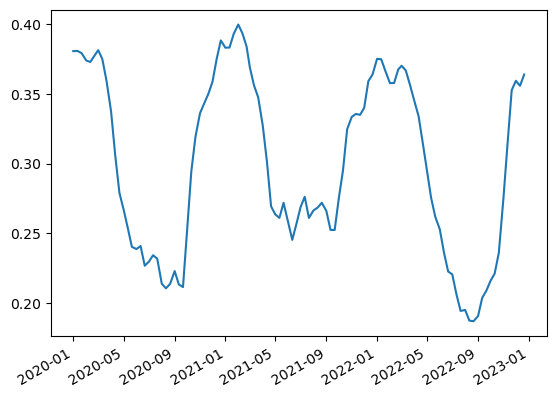

In [6]:
sma.data.swvl3.plot()

In [7]:
sdate_ts = pd.Timestamp(aa.start_date)
sdate_dk = sdate_ts.replace(day=utils.nearest_dekad(sdate_ts.day))
sdate_sma = sdate_dk - relativedelta(days=20)

In [8]:
def aa_new(required_sdate: pd.Timestamp) -> config.AnalysisArgs:
    """
    Helper function to quickly return modified arguments
    """
    # Makes sure start date is in dekads and the required format
    sdate = required_sdate.replace(day=utils.nearest_dekad(required_sdate.day))
    return config.AnalysisArgs(aa.latitude,aa.longitude,sdate.strftime('%Y%m%d'),aa.end_date)


In [10]:
tmp = dri.SMA_ECMWF(cf,aa_new(sdate_sma))

In [11]:
fpath = tmp.download_obj_hourly.download_file_path
fpath

'output\\soilwater_20191211-20221231_52.5_1.25_hourly.nc'

In [13]:
myfile='output/soilwater_20191211-20221231_52.5_1.25_hourly.nc'

In [15]:
xr.open_dataset(myfile).swvl3#.plot()

<xarray.DataArray 'swvl3' (time: 26808, latitude: 1, longitude: 1)>
[26808 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 1.15
  * latitude   (latitude) float32 52.4
  * time       (time) datetime64[ns] 2019-12-11T13:00:00 ... 2022-12-31T01:00:00
Attributes:
    units:      m**3 m**-3
    long_name:  Volumetric soil water layer 3

<Axes: >

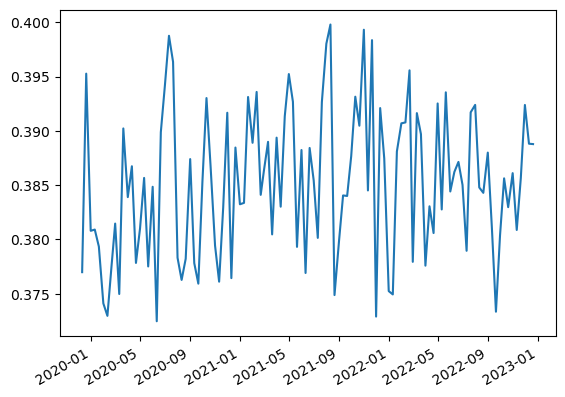

In [9]:
cdi.sma.data.swvl3.plot()

In [57]:
cdi.index_shortname(caps=False)

TypeError: 'str' object is not callable

In [54]:

cdi.download()
cdi.process()

2023-04-17  13:16:27 INFO Downloaded file 'output\precip_19850101-20221231_monthly_52.5_1.25.nc' already exists.
2023-04-17  13:16:27 INFO Downloaded files available.
2023-04-17  13:16:27 INFO Downloaded files available.
2023-04-17  13:16:27 INFO Computing Combined Drought Indicator...
2023-04-17  13:16:27 INFO Initiating processing of ERA5 daily data.
2023-04-17  13:16:27 INFO Input precipitation, 456 values: 0.000 0.005 
2023-04-17  13:16:27 INFO 

2023-04-17  13:16:27 DEBUG scaled values: 0.002 0.012
2023-04-17  13:16:27 DEBUG alphas: 9.687 17.504 betas: 0.000 0.001
2023-04-17  13:16:27 INFO SPI, 456 values: -3.046 2.676
2023-04-17  13:16:29 INFO Completed processing of ERA5 soil water data.
2023-04-17  13:16:31 INFO Completed processing of ERA5 fAPAR data.
2023-04-17  13:16:31 INFO Completed processing of ERA5 CDI data.


,tp,spi,smant,fpanv,CDI
2020-01-01,NaN,NaN,NaN,NaN,NaN
2020-01-11,NaN,NaN,NaN,NaN,NaN
2020-01-21,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.001882,0.928141,NaN,NaN,NaN
2020-02-11,0.001882,0.928141,-0.08,-1.078,0.0
...,...,...,...,...,...
2022-11-11,0.000909,-1.089360,-1.81,1.780,2.0
2022-11-21,0.000909,-1.089360,-0.40,NaN,NaN
2022-12-01,0.002387,-0.953641,NaN,NaN,NaN
2022-12-11,0.002387,-0.953641,NaN,NaN,NaN


In [35]:
warns = []
for i,r in cdi.df_shifted.iterrows():
    spi_warn = r['spi'] < -1
    warns.append(r['spi'] < -1)

In [48]:
cdi.df_shifted.isna().any(axis=1)

2020-01-01     True
2020-01-11     True
2020-01-21     True
2020-02-01     True
2020-02-11    False
              ...  
2022-11-11    False
2022-11-21     True
2022-12-01     True
2022-12-11     True
2022-12-21     True
Length: 108, dtype: bool

In [53]:

def calc_cdi(r):
    spi_ = r['spi'] < -1
    sma_ = r['smant'] < -1
    fpr_ = r['fpanv'] < -1
    if r.isna().any():
        return np.nan
    elif spi_ and sma_ and fpr_:
        return 4
    elif spi_ and fpr_:
        return 3
    elif spi_ and sma_:
        return 2
    elif spi_:
        return 1
    else:
        return 0
    
cdi.df_shifted.apply(calc_cdi,axis=1)

2020-01-01    NaN
2020-01-11    NaN
2020-01-21    NaN
2020-02-01    NaN
2020-02-11    0.0
             ... 
2022-11-11    2.0
2022-11-21    NaN
2022-12-01    NaN
2022-12-11    NaN
2022-12-21    NaN
Length: 108, dtype: float64

In [14]:
(cdi.sma_shifted < -1).to_numpy().flatten()

array([False, False, False, False, False, False, False,  True,  True,
        True, False, False,  True,  True,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True, False, False, False, False])